### Convolutional Neural Network on MNIST dataset

In [4]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
#training
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/5], Step [100/600], Loss: 0.1225
Epoch [1/5], Step [200/600], Loss: 0.0476
Epoch [1/5], Step [300/600], Loss: 0.0754
Epoch [1/5], Step [400/600], Loss: 0.0599
Epoch [1/5], Step [500/600], Loss: 0.0237
Epoch [1/5], Step [600/600], Loss: 0.1151
Epoch [2/5], Step [100/600], Loss: 0.0184
Epoch [2/5], Step [200/600], Loss: 0.0182
Epoch [2/5], Step [300/600], Loss: 0.0289
Epoch [2/5], Step [400/600], Loss: 0.0490
Epoch [2/5], Step [500/600], Loss: 0.0186
Epoch [2/5], Step [600/600], Loss: 0.0972
Epoch [3/5], Step [100/600], Loss: 0.1134
Epoch [3/5], Step [200/600], Loss: 0.1508
Epoch [3/5], Step [300/600], Loss: 0.0312
Epoch [3/5], Step [400/600], Loss: 0.0782
Epoch [3/5], Step [500/600], Loss: 0.0990
Epoch [3/5], Step [600/600], Loss: 0.0562
Epoch [4/5], Step [100/600], Loss: 0.0102
Epoch [4/5], Step [200/600], Loss: 0.0149
Epoch [4/5], Step [300/600], Loss: 0.0437
Epoch [4/5], Step [400/600], Loss: 0.0206
Epoch [4/5], Step [500/600], Loss: 0.0586
Epoch [4/5], Step [600/600], Loss:

In [7]:
#testing
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 99.07 %


### RNN for generating text 
https://towardsdatascience.com/writing-like-shakespeare-with-machine-learning-in-pytorch-d77f851d910c

In [28]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# Open shakespeare text file and read in data as `text`
with open('data/shakespeare.txt', 'r') as f:
    text = f.read()

In [29]:
# Showing the first 100 characters
text[:100]

'This is the 100th Etext file presented by Project Gutenberg, and\nis presented in cooperation with Wo'

In [30]:
# encoding the text and map each character to an integer and vice versa

# We create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

# Encode the text
encoded = np.array([char2int[ch] for ch in text])

# Showing the first 100 encoded characters
encoded[:100]

array([30, 68, 10, 85, 77, 10, 85, 77, 49, 68, 27, 77,  0, 65, 65, 49, 68,
       77, 56, 49, 27, 41, 49, 77, 48, 10, 24, 27, 77, 78, 63, 27, 85, 27,
       74, 49, 27, 87, 77, 33, 50, 77, 13, 63, 75, 54, 27, 43, 49, 77, 35,
       59, 49, 27, 74, 33, 27, 63, 62, 89, 77, 79, 74, 87,  9, 10, 85, 77,
       78, 63, 27, 85, 27, 74, 49, 27, 87, 77, 10, 74, 77, 43, 75, 75, 78,
       27, 63, 79, 49, 10, 75, 74, 77, 18, 10, 49, 68, 77, 52, 75])

In [31]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot
    
# Defining method to make mini-batches for training
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y


In [32]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [33]:
# Declaring the model
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        #define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        #define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        #define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        #get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        #pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        out = out.contiguous().view(-1, self.n_hidden)
        
        #put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden


In [34]:
# Declaring the train method
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                      
# Define and print the net
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(91, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=91, bias=True)
)


In [35]:
# Declaring the hyperparameters
batch_size = 128
seq_length = 100
n_epochs = 5 # start smaller if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50)

# Saving the model
model_name = 'rnn_20_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)
    
# Defining a method to generate the next character
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h
        
# Declaring a method to generate new text
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

Epoch: 1/5... Step: 50... Loss: 3.2490... Val Loss: 3.2136
Epoch: 1/5... Step: 100... Loss: 3.1598... Val Loss: 3.1830
Epoch: 1/5... Step: 150... Loss: 2.8971... Val Loss: 2.8927
Epoch: 1/5... Step: 200... Loss: 2.6111... Val Loss: 2.5472
Epoch: 1/5... Step: 250... Loss: 2.3613... Val Loss: 2.3088
Epoch: 1/5... Step: 300... Loss: 2.2522... Val Loss: 2.1792
Epoch: 1/5... Step: 350... Loss: 2.1404... Val Loss: 2.0816


KeyboardInterrupt: 

In [ ]:
# Generating new text
print(sample(net, 1000, prime='A', top_k=5))

Above, I had to interrupt the process because it took very long! Perhaps if you are curious, you could try this code on the server and get the results. Or take a look at the results generated in the website provided above.

### Generative Adversarial Network

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [14]:
matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

In [15]:
# Data params
data_mean = 4
data_stddev = 1.25

In [16]:
# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)


In [17]:
print("Using data [%s]" % (name))


Using data [Only 4 moments]


In [18]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian


In [19]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

In [20]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

In [21]:
def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0: D (0.6358835697174072 real_err, 0.7440698146820068 fake_err) G (0.6455076932907104 err); Real Dist ([3.985840771198273, 1.2675471781292351]),  Fake Dist ([0.4671567519903183, 0.0033515308554551973]) 
Epoch 100: D (0.5660937428474426 real_err, 0.5849903225898743 fake_err) G (0.8124746084213257 err); Real Dist ([4.029280935108662, 1.2393676642988891]),  Fake Dist ([2.7715966992378234, 0.005839416731167195]) 
Epoch 200: D (0.3237815201282501 real_err, 0.6025383472442627 fake_err) G (0.3204660415649414 err); Real Dist ([4.004914841830731, 1.2540001957698945]),  Fake Dist ([0.6617648614645004, 0.9032486316563701]) 
Epoch 300: D (0.7155933380126953 real_err, 1.025075078010559 fake_err) G (0.3850141167640686 err); Real Dist ([3.963545500040054, 1.2446940155738904]),  Fake Dist ([2.06364945435524, 0.17597738897138593]) 
Epoch 400: D (0.6410775780677795 real_err, 0.5808625221252441 fake_err) G (0.7881188988685608 err); Real Dist ([3.9642810295820237, 1.257673872921598]),  Fake Dist ([7

Epoch 4000: D (0.6927763819694519 real_err, 0.6933629512786865 fake_err) G (0.6932995319366455 err); Real Dist ([3.989915632545948, 1.3034143899230135]),  Fake Dist ([4.061218119144439, 1.2722264230429203]) 
Epoch 4100: D (0.6925982236862183 real_err, 0.6934898495674133 fake_err) G (0.6934146881103516 err); Real Dist ([3.966803432777524, 1.2482069361780825]),  Fake Dist ([3.997150721311569, 1.1903797890023975]) 
Epoch 4200: D (0.6922729015350342 real_err, 0.6938718557357788 fake_err) G (0.6925795674324036 err); Real Dist ([3.997735216259956, 1.2266235428578305]),  Fake Dist ([3.923613603591919, 1.2716865626169098]) 
Epoch 4300: D (0.6947535872459412 real_err, 0.6906834244728088 fake_err) G (0.6945594549179077 err); Real Dist ([4.095552872896194, 1.27868310937019]),  Fake Dist ([4.042745877504348, 1.2089741169738606]) 
Epoch 4400: D (0.6931111812591553 real_err, 0.6940391659736633 fake_err) G (0.6926850080490112 err); Real Dist ([4.067909948244691, 1.3037868764770868]),  Fake Dist ([4.0

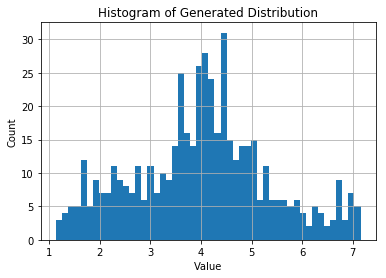

In [23]:
def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()


train()
